In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3

In [55]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
import shap

Fazendo a junção de duas tabelas para ter mais informações para a probabilide de churn

In [57]:
conexao = sqlite3.connect(r'C:\Users\heloi\OneDrive\Desktop\Projeto - Inlytics\Dataset\db_cliente_sqlite\empresa_cliente_db.db')

df_customer_user = pd.read_sql('SELECT * FROM customer_user', conexao)
df_customer_sales = pd.read_sql('SELECT * FROM customer_sales', conexao)
df_rfm = pd.read_csv(r'C:\Users\heloi\OneDrive\Desktop\Projeto - Inlytics\dados_temporarios_rfm_csv\rfm_dados_gerais.csv')
conexao.close()

df_customer_sales['InvoiceDate'] = pd.to_datetime(df_customer_sales['InvoiceDate'])
df_customer_sales['DateStartBase'] = df_customer_sales['InvoiceDate'].dt.strftime('%Y-%m-%d')

df_customer_min_invoice = df_customer_sales.groupby('CustomerID')['DateStartBase'].agg('min').reset_index()

df_user_rfm = pd.merge(df_customer_user, df_rfm, on='CustomerID', how='left')
df_all_data = pd.merge(df_user_rfm, df_customer_min_invoice, on='CustomerID', how='left')

df_all_data.head(10)

,CustomerID,Churn,Tenure,PreferredLoginDevice,PreferredPaymentMode,Gender,NumberOfDeviceRegistered,SatisfactionScore,MaritalStatus,Complain,CouponUsed,NomeCustomer,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,Segment,DateStartBase
0,17850.0,1,4.0,Mobile Phone,Debit Card,Female,3.0,2,Single,1,1.0,Srta. Amanda Sousa,372.0,34.0,5391.21,1.0,5.0,5.0,Promising,2010-12-01
1,13047.0,1,NaN,Phone,UPI,Male,4.0,3,Single,1,0.0,Joaquim Câmara,32.0,10.0,3237.54,4.0,5.0,5.0,Champions,2010-12-01
2,12583.0,1,NaN,Phone,Debit Card,Male,4.0,3,Single,1,0.0,Cauã Rocha,3.0,15.0,7281.38,5.0,5.0,5.0,Champions,2010-12-01
3,13748.0,1,0.0,Phone,Debit Card,Male,4.0,5,Single,0,0.0,Sr. Otávio Andrade,96.0,5.0,948.25,2.0,4.0,4.0,Others,2010-12-01
4,15100.0,1,0.0,Phone,CC,Male,3.0,5,Single,0,1.0,Caleb Cunha,334.0,3.0,876.00,1.0,3.0,3.0,Others,2010-12-01
5,15291.0,1,0.0,Computer,Debit Card,Female,5.0,5,Single,1,4.0,Sofia Pereira,26.0,15.0,4668.30,4.0,5.0,5.0,Champions,2010-12-01
6,14688.0,1,NaN,Phone,Cash on Delivery,Male,3.0,2,Divorced,0,0.0,Gael Henrique Silva,8.0,21.0,5630.87,5.0,5.0,5.0,Champions,2010-12-01
7,17809.0,1,NaN,Phone,CC,Male,3.0,2,Divorced,1,2.0,Dr. Henry Machado,16.0,12.0,5411.91,4.0,5.0,5.0,Champions,2010-12-01
8,15311.0,1,NaN,Phone,Debit Card,Male,5.0,3,None,0,1.0,João Lucas Abreu,1.0,91.0,60767.90,5.0,5.0,5.0,Champions,2010-12-01
9,14527.0,1,4.0,Mobile Phone,Cash on Delivery,Female,3.0,3,Divorced,0,9.0,Mariana Fernandes,3.0,55.0,8508.82,5.0,5.0,5.0,Champions,2010-12-05


In [58]:
df_all_data.columns

Index(['CustomerID', 'Churn', 'Tenure', 'PreferredLoginDevice',
       'PreferredPaymentMode', 'Gender', 'NumberOfDeviceRegistered',
       'SatisfactionScore', 'MaritalStatus', 'Complain', 'CouponUsed',
       'NomeCustomer', 'Recency', 'Frequency', 'Monetary', 'R_Score',
       'F_Score', 'M_Score', 'Segment', 'DateStartBase'],
      dtype='object')

Verificação do desbalanceamento da Target - Churn

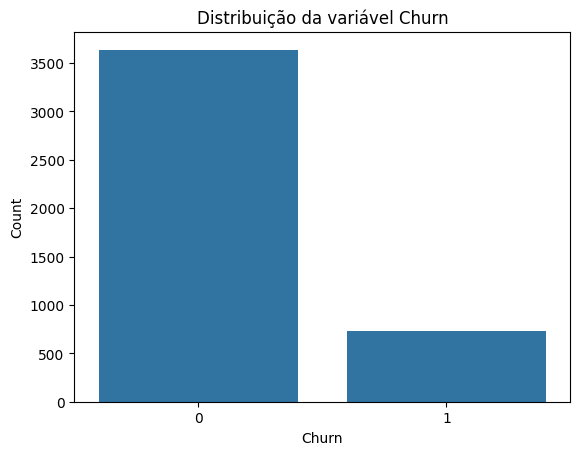

In [39]:
target_counts = df_all_data['Churn'].value_counts().reset_index()
target_counts.columns = ['Churn', 'Count']

sns.barplot(x='Churn', y='Count', data=target_counts)
plt.title('Distribuição da variável Churn')
plt.show()

Com base nas informações anteriores irei seguir os seguintes passos para utilizar a Random Forest:

- Tratamento de valores ausentes
- Codificação da variável categóricas
- Remoção de colunas irrelevantes ou duplicadas (RFE)
- Balanceamento de classes (SMOTE)

In [ ]:
df = df_all_data.copy()
df.drop(columns=['CustomerID', 'NomeCustomer'], inplace=True)

categorical_features = ['PreferredLoginDevice', 'PreferredPaymentMode', 'Gender', 'MaritalStatus', 'Segment']
numeric_features = [col for col in df.columns if col not in categorical_features + ['Churn']]


#FAZER A SEPARAÇÃO COM SPLIT (LEMBRAR DO STRATIFY)

NameError: name 'df_all_data' is not defined

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='mean'))
])

categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])


In [ ]:
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier

# Estimador para o RFE (pode ser DecisionTree, que é mais rápido)
estimator_rfe = DecisionTreeClassifier()

# Pipeline até a seleção de features (RFE)
pipeline_arvore_base = ImbPipeline([
    ('preprocessor', preprocessor),        # Imputação e codificação
    ('smote', SMOTE()),                    # Balanceamento de classes
    ('rfe', RFE(estimator=estimator_rfe, n_features_to_select=10)),  # Seleção de features
])

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Pipeline para Decision Tree
pipeline_dt = ImbPipeline([
    ('base', pipeline_arvore_base),
    ('classifier', DecisionTreeClassifier())
])

# Pipeline para Random Forest
pipeline_rf = ImbPipeline([
    ('base', pipeline_arvore_base),
    ('classifier', RandomForestClassifier())
])

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression

pipeline_logit_treino = ImbPipeline([
    ('preprocessor', preprocessor),        # Imputação e codificação
    ('smote', SMOTE()),                    # Balanceamento de classes
    ('rfe', RFE(estimator=LogisticRegression(max_iter=1000), n_features_to_select=10)),  # Seleção de features
    ('standardscaler', StandardScaler()),  # Padronização
    ('pca', PCA(n_components=0.95)),       # Tratamento de multicolinearidade
    ('classifier', LogisticRegression(max_iter=1000))  # Modelo
])


Daqui para baixo é apenas para conferencia de informação

In [64]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# Supondo que seu DataFrame se chama df_all_data
df = df_all_data.copy()

# Remover colunas irrelevantes para o modelo
df.drop(columns=['CustomerID', 'NomeCustomer', 'DateStartBase'], inplace=True)

# Definir variáveis categóricas e numéricas
categorical_cols = ['PreferredLoginDevice', 'PreferredPaymentMode', 'Gender', 'MaritalStatus', 'Segment']
numeric_cols = [col for col in df.columns if col not in categorical_cols + ['Churn']]

X = df.drop('Churn', axis=1)
y = df['Churn']

# Pré-processamento separado para numéricas e categóricas
numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numeric_cols),
    ('cat', categorical_transformer, categorical_cols)
])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)


In [66]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier

# Pipeline para pré-processar e aplicar RFE
rfc_estimator = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')

pipeline_rfe = Pipeline([
    ('preprocessor', preprocessor),
    ('rfe', RFE(estimator=rfc_estimator, n_features_to_select=15))
])

pipeline_rfe.fit(X_train, y_train)

# Recuperar nomes das features após one-hot encoding
preprocessor_fit = pipeline_rfe.named_steps['preprocessor']
num_features = numeric_cols
cat_features = preprocessor_fit.named_transformers_['cat']['onehot'].get_feature_names_out(categorical_cols)
all_features = np.concatenate([num_features, cat_features])

mask = pipeline_rfe.named_steps['rfe'].support_
selected_features = all_features[mask]
print("Features selecionadas pelo RFE:")
print(selected_features)


Features selecionadas pelo RFE:
['Tenure' 'NumberOfDeviceRegistered' 'SatisfactionScore' 'Complain'
 'CouponUsed' 'Recency' 'Frequency' 'Monetary' 'R_Score' 'F_Score'
 'M_Score' 'PreferredLoginDevice_Mobile Phone' 'Gender_Female'
 'MaritalStatus_Married' 'MaritalStatus_Single']


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.pipeline import make_pipeline
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score

models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, class_weight='balanced', solver='liblinear'),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42)
}

results = {}
for name, model in models.items():
    pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('feature_selector', RFE(estimator=rfc_estimator, n_features_to_select=15)),
        ('classifier', model)
    ])
    scores = cross_val_score(pipe, X_train, y_train, cv=5, scoring='roc_auc')
    results[name] = scores.mean()
    print(f"{name} AUC médio: {scores.mean():.4f}")


Logistic Regression AUC médio: 0.7522
Random Forest AUC médio: 0.8506
Gradient Boosting AUC médio: 0.8662


In [68]:
from sklearn.model_selection import GridSearchCV

best_model = RandomForestClassifier(random_state=42, class_weight='balanced')

pipeline_final = Pipeline([
    ('preprocessor', preprocessor),
    ('feature_selector', RFE(estimator=rfc_estimator, n_features_to_select=15)),
    ('classifier', best_model)
])

param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2, 5]
}

grid_search = GridSearchCV(pipeline_final, param_grid, cv=3, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Melhores hiperparâmetros:", grid_search.best_params_)

# Avaliar no teste
y_pred = grid_search.predict(X_test)
y_proba = grid_search.predict_proba(X_test)[:, 1]

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))
print("ROC AUC no teste:", roc_auc_score(y_test, y_proba))


Melhores hiperparâmetros: {'classifier__max_depth': None, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 200}
              precision    recall  f1-score   support

           0       0.91      0.95      0.93      1091
           1       0.67      0.52      0.58       221

    accuracy                           0.88      1312
   macro avg       0.79      0.73      0.76      1312
weighted avg       0.87      0.88      0.87      1312

ROC AUC no teste: 0.8871805931707802


In [ ]:
import shap

# Extrair modelo treinado e dados transformados
final_model = grid_search.best_estimator_.named_steps['classifier']
X_test_transformed = grid_search.best_estimator_.named_steps['preprocessor'].transform(X_test)
X_test_selected = X_test_transformed[:, mask]

explainer = shap.TreeExplainer(final_model)
shap_values = explainer.shap_values(X_test_selected)

shap.summary_plot(shap_values[1], features=X_test_selected, feature_names=selected_features)


NotFittedError: This ColumnTransformer instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.